In [7]:
from trendAnalyserPy import StockTrendAnalyzer
from backtestPy import Backtester
from optimizerPy import Optimizer
from stockData import StockData
import yfinance as yf
import numpy as np
import pandas as pd
import datetime as dt

In [19]:
class Trading:
    def __init__(self, symbol, start_date, end_date, interval, specific_given_date=None):
        self.symbol = symbol
        self.start_date = start_date
        self.end_date = end_date
        self.interval = interval
        self.stock_intraday = None

        # Initialize the detector with properly loaded data
        self._load_data(specific_given_date)
        self.detector = StockTrendAnalyzer(symbol, start_date, end_date, self.stock, interval)
        self.backtester = Backtester(symbol, start_date, end_date, interval, self.stock)
        self.optimizer = Optimizer(self.backtester)

        self.peaks = []
        self.throughs = []
        self.uptrends = []
        self.downtrends = []
        self.peaks_intraday = []
        self.troughs_intraday = []
        self.uptrends_intraday = []
        self.downtrends_intraday = []
        

    def _load_data(self, specific_given_date):
        """
        Load stock data, considering intraday intervals with period and start_date.
        """
        self.load_data = StockData(symbol, start_date, end_date, interval, specific_given_date)
        if self.interval in ['1m', '2m', '5m', '15m', '30m', '60m', '90m']: 
            self.stock, self.stock_intraday = self.load_data.load_intraday_data()
        else:
            self.stock = self.load_data.load_daily_data()

    def analyze_stock(self):
        """
        Analyze stock trends for the initialized symbol and time period.
        """
        analyzer = self.detector
        analyzer.data = self.stock  # Ensure detector works with the loaded data
        self.peaks, self.troughs = analyzer.find_peaks_and_troughs()
        self.uptrends, self.downtrends = analyzer.identify_trends()

        # Print trend summary
        print(f"\nTrend Summary for {self.symbol}:")
        for summary in analyzer.get_trend_summary():
            print(summary)

        # Generate visualization
        if self.stock_intraday is None:
            plt = analyzer.visualize_trends()
            plt.show()

        if self.stock_intraday is not None:
            analyzer.data = self.stock_intraday
            self.peaks_intraday, self.troughs_intraday = analyzer.find_peaks_and_troughs()
            self.uptrends_intraday, self.downtrends_intraday = analyzer.identify_trends()
            analyzer.visualize_intraday_trends()
            
 
        return analyzer

    def analyze_and_backtest(self, analyzer, strategy=None, **kwargs):
        """
        Perform analysis to find peaks and troughs, and then backtest using the results.
        """
        # Step 1: Analyze data to find peaks and troughs
        peaks = self.peaks
        troughs = self.troughs
        uptrends = self.uptrends
        downtrends = self.downtrends
    
        # Step 2: Update params with peaks and troughs
        params = {}
        params["peaks"] = peaks
        params["troughs"] = troughs
        params["uptrends"] = uptrends
        params["downtrends"] = downtrends
    
        # Step 3: Initialize Backtester with data and params
        backtester = Backtester(
            symbol=self.symbol,
            start_date=self.start_date,
            end_date=self.end_date,
            interval=self.interval,
            data=self.stock,
            initial_capital=10000,
            strategy=strategy,
            **params
        )
    
        # Step 4: Run the backtest and return results
        results = backtester.backtest(strategy, **kwargs)
        plt = backtester.visualize_data()
        plt.show()
        if results is not None:
            backtester.print_results(results)
        return backtester

    def backtest_intraday(self, analyzer, strategy=None, **kwargs):
        params = {}
        params["peaks"] = self.peaks
        params["troughs"] = self.troughs
        params["uptrends"] = self.uptrends
        params["downtrends"] = self.downtrends
        params["peaks_intraday"] = self.peaks_intraday
        params["troughs_intraday"] = self.troughs_intraday
        params["uptrends_intraday"] = self.uptrends_intraday
        params["downtrends_intraday"] = self.downtrends_intraday
        
        
    def optimize(self, strategy, param_ranges, initial_guess):
        """
        Optimize trading strategy parameters.
        """
        backtester = Backtester(self.stock)
        optimizer = Optimizer(backtester)
        return optimizer.optimize(strategy, param_ranges, initial_guess)


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed



Trend Summary for SPY:
Uptrend: Start: 2024-01-17 (Price: $472.29), End: 2024-04-04 (Price: $513.07), Change: 8.6%
Uptrend: Start: 2024-05-02 (Price: $505.03), End: 2024-05-23 (Price: $525.96), Change: 4.1%
Uptrend: Start: 2024-06-25 (Price: $544.83), End: 2024-07-24 (Price: $541.23), Change: -0.7%
Uptrend: Start: 2024-08-28 (Price: $558.30), End: 2024-09-03 (Price: $552.08), Change: -1.1%
Uptrend: Start: 2024-09-20 (Price: $568.25), End: 2024-10-31 (Price: $568.64), Change: 0.1%
Uptrend: Start: 2024-11-15 (Price: $585.75), End: 2024-12-06 (Price: $607.81), Change: 3.8%
Downtrend: Start: 2024-04-04 (Price: $513.07), End: 2024-04-26 (Price: $508.26), Change: -0.9%
Downtrend: Start: 2024-08-01 (Price: $543.01), End: 2024-08-19 (Price: $559.61), Change: 3.1%


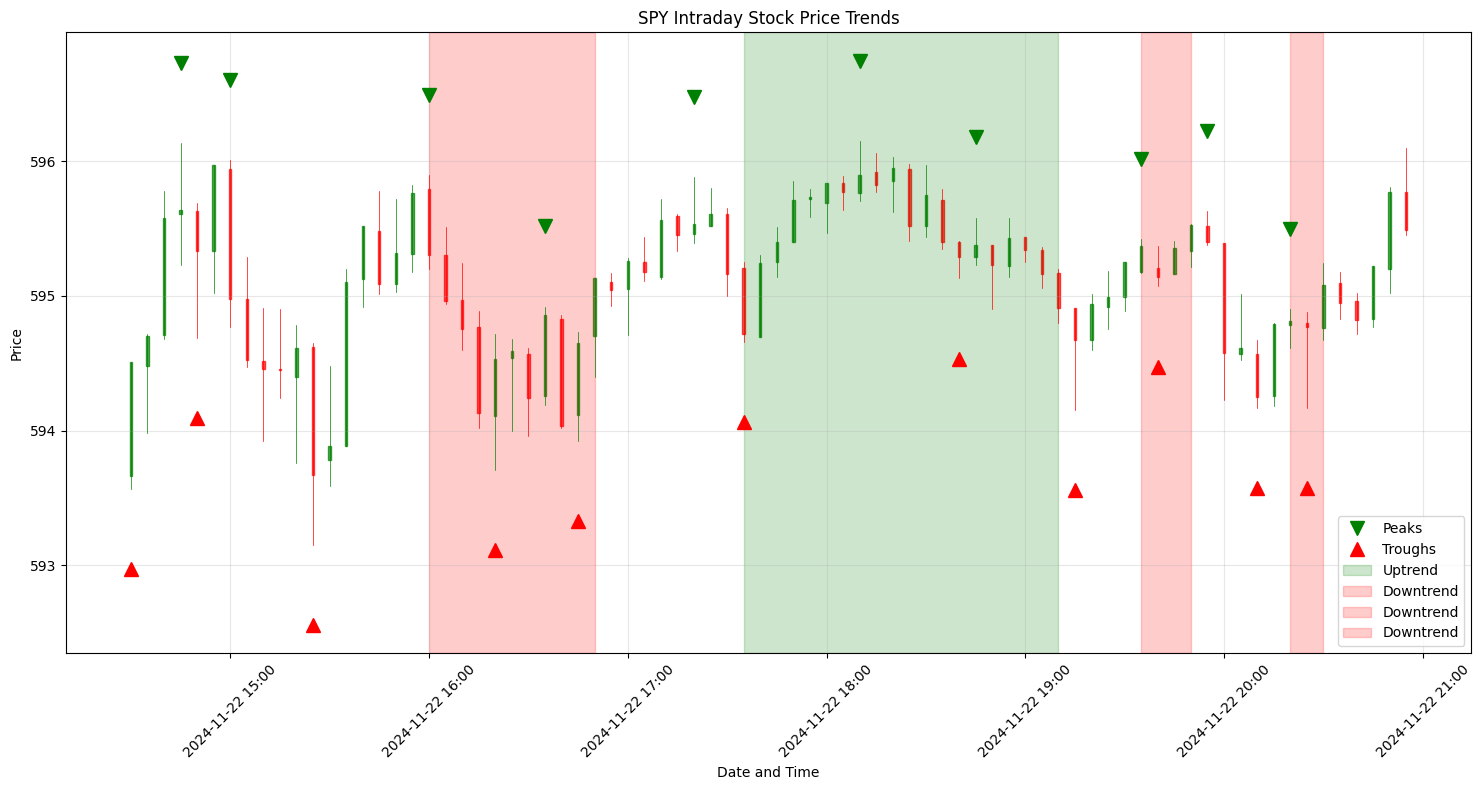

In [14]:
symbol='SPY'
start_date='2024-01-03' 
end_date='2024-03-10'
interval='5m'
specific_given_date='2024-11-22'
trading = Trading(symbol, start_date, end_date, interval=interval, specific_given_date=specific_given_date)
analyzer = trading.analyze_stock()
#backtest = trading.analyze_and_backtest(analyzer)
#backtest = trading.analyze_and_backtest(analyzer, strategy=sma_crossover_strategy, sma_s=5, sma_l=20, take_profit=0.03, stop_loss=0.02)

In [18]:
trading.stock.iloc[245]

Open            602.969971
High            604.320007
Low             602.469971
Close           603.630005
Adj Close       603.630005
Volume            31746000
CandleType                
ReversalType              
CandleMove                
Name: 2024-12-02 00:00:00, dtype: object

In [3]:
def sma_crossover_strategy(data: pd.DataFrame, **kwargs) -> pd.DataFrame:
    """
    Simple Moving Average (SMA) crossover strategy for long positions only.
    Generates buy signals when short-term SMA crosses above long-term SMA,
    and exit signals when short-term SMA crosses below long-term SMA.
    
    Args:
        data (pd.DataFrame): DataFrame with OHLCV data
        **kwargs: Strategy parameters including:
            - sma_s (int): Short-term SMA period (default: 20)
            - sma_l (int): Long-term SMA period (default: 50)
            - take_profit (float): Take profit percentage (default: None)
            - stop_loss (float): Stop loss percentage (default: None)
    
    Returns:
        pd.DataFrame: DataFrame with Position column (0 for no position, 1 for long)
    """
    # Get parameters from kwargs with defaults
    sma_s = kwargs.get('sma_s', 20)
    sma_l = kwargs.get('sma_l', 50)
    
    # Calculate SMAs
    data['SMA_Short'] = data['Close'].rolling(window=sma_s).mean()
    data['SMA_Long'] = data['Close'].rolling(window=sma_l).mean()
    
    # Initialize position column
    data['Position'] = 0
    
    # Generate signals
    # Long entry signal: Short SMA crosses above Long SMA
    data.loc[data['SMA_Short'] > data['SMA_Long'], 'Position'] = 1
    
    # Exit signal: Short SMA crosses below Long SMA
    data.loc[data['SMA_Short'] < data['SMA_Long'], 'Position'] = 0
    
    # Fill NaN values with 0
    data['Position'] = data['Position'].fillna(0)
    
    # Return DataFrame with Position column
    return data[['Position']]

# Add name attribute for strategy identification
sma_crossover_strategy._name_ = 'Long_Only_SMA_Crossover'

In [6]:
backtest.get_trades_info()

,type,entry_price,exit_price,entry_idx,exit_idx,profit_percent,profit_money,open_date,close_date
0,long,472.290009,513.070007,9,63,8.634525,863.452498,2024-01-17,2024-04-04
1,short,505.410004,508.260010,77,79,-0.563900,-56.389982,2024-04-24,2024-04-26
2,long,505.029999,525.960022,83,98,4.144313,414.431286,2024-05-02,2024-05-23
3,long,544.830017,541.229980,119,139,-0.660763,-66.076327,2024-06-25,2024-07-24
4,long,558.299988,552.080017,164,167,-1.114091,-111.409114,2024-08-28,2024-09-03
5,long,568.250000,568.640015,180,209,0.068634,6.863434,2024-09-20,2024-10-31
6,long,585.750000,607.809998,220,234,3.766111,376.611141,2024-11-15,2024-12-06


[*********************100%%**********************]  1 of 1 completed


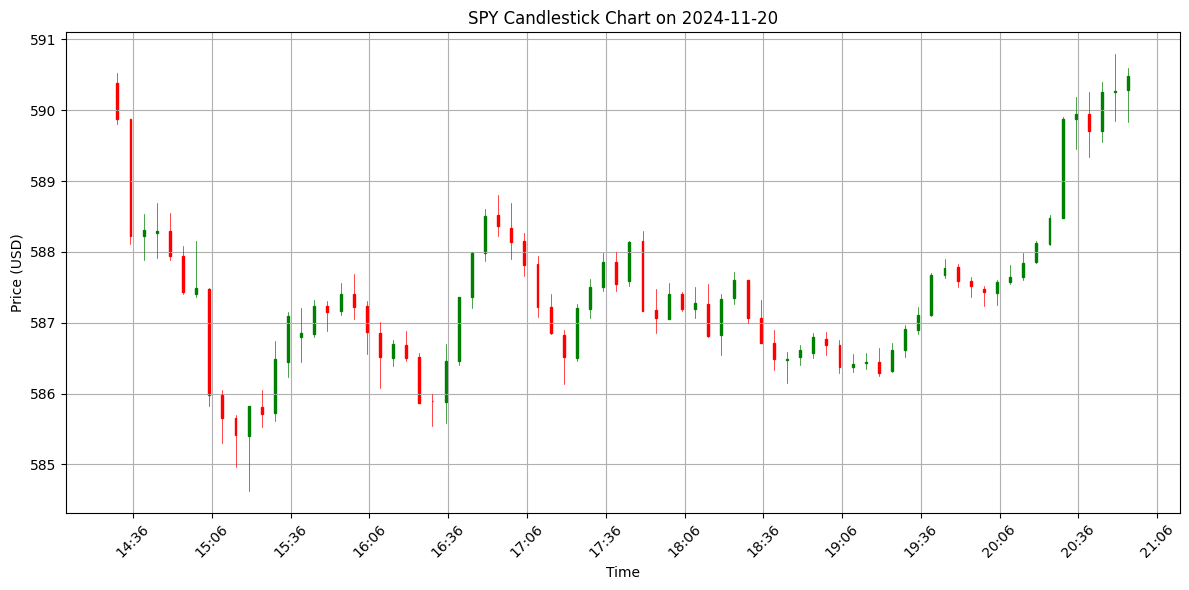

In [7]:
import datetime as dt
import matplotlib.dates as mdates
import mplfinance as mpf
from mplfinance.original_flavor import candlestick_ohlc
import matplotlib.pyplot as plt


today = dt.datetime.today()
start_date = (today - dt.timedelta(days=59)).strftime("%Y-%m-%d")
end_date = today.strftime("%Y-%m-%d")

data = yf.download("SPY", start=start_date, end=end_date, interval="5m")

# Ensure the index is timezone-aware and normalized
data.index = data.index.tz_convert("America/New_York")

specific_date='2024-11-20'
# Define the start and end of the specific date
specific_date_start = pd.Timestamp(specific_date + " 00:00:00").tz_localize("America/New_York")
specific_date_end = specific_date_start + pd.Timedelta(days=1)

# Filter data for the specific date
specific_date_data = data[(data.index >= specific_date_start) & (data.index < specific_date_end)]

# Check if data exists for the specified date
if specific_date_data.empty:
    print(f"No data available for {specific_date}.")
else:
    # Prepare data for mplfinance
    specific_date_data.index.name = "Date"  # Set the index name for mplfinance
    specific_date_data = specific_date_data[["Open", "High", "Low", "Close", "Volume"]]  # Ensure required columns are present

    # Plot the candlestick chart
    specific_date_data.reset_index(inplace=True)  # Reset index to use in plotting
    #print(specific_date_data)
    specific_date_data["Timestamp"] = specific_date_data["Date"].apply(mdates.date2num)  # Convert to matplotlib's date format

    # Prepare OHLC data for candlestick_ohlc
    ohlc_data = specific_date_data[["Timestamp", "Open", "High", "Low", "Close"]].values

    # Plotting with matplotlib
    fig, ax = plt.subplots(figsize=(12, 6))

    # Candlestick chart
    candlestick_ohlc(ax, ohlc_data, width=0.0005, colorup="green", colordown="red")

    # Formatting the x-axis
    ax.xaxis.set_major_locator(mdates.MinuteLocator(interval=30))  # Adjust tick interval
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))

    # Add grid, labels, and title
    ax.grid(True)
    ax.set_xlabel("Time")
    ax.set_ylabel("Price (USD)")
    ax.set_title(f"{symbol} Candlestick Chart on {specific_date}")

    # Rotate x-axis labels for better readability
    plt.xticks(rotation=45)

    # Show the chart
    plt.tight_layout()
    plt.show()

In [44]:

today = dt.datetime.today()
start_date = (today - dt.timedelta(days=356)).strftime("%Y-%m-%d")
end_date = today.strftime("%Y-%m-%d")
stock = yf.download('SPY', start=start_date, end=end_dated, interval='1d')


[*********************100%%**********************]  1 of 1 completed
